In [1]:
from torch.nn import Module, Sequential, Linear, LeakyReLU, Sigmoid, BCELoss
from torch.utils.data import DataLoader, TensorDataset
from torch import device, cuda
from torch.optim import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import pandas as pd
from tqdm import tqdm
import torch
from time import time
import os

import sys
sys.path.append('..')  
from src.utils.RawDataReader import RawDataReader



In [2]:
reader = RawDataReader()
labels = reader.get_labels()
datasets = reader.get_datasets()

In [3]:
class SingleHeadModel(Module):
    def __init__(self, feature_count:int, hidden_count:int=5):
        super(SingleHeadModel, self).__init__()

        self.slope = 0.001

        self.model = Sequential(
            *[self.linear_block(feature_count,feature_count) for _ in range(hidden_count)],
            Linear(in_features=feature_count, out_features=1),
            Sigmoid()
        )

    def linear_block(self, in_features, out_features):
        return Sequential(
            Linear(in_features=in_features, out_features=out_features),
            LeakyReLU(negative_slope=self.slope)
        )
    
    def forward(self, x):
        return self.model(x)


In [4]:
f1_scores = {}
f1_score_validations = {}
models = {}
num_labels = labels.shape[1]

validation_split = 0.05
test_split = 0.20
batch_size = 2048
learning_rate = 0.001
epochs = 99
hidden_layers = 10

num_folds = 10

random_state = 1

device = device("cuda" if cuda.is_available() else "cpu")
print(f"Training on {device}")

Training on cuda


In [5]:
stratified_folds = StratifiedKFold(n_splits=num_folds, random_state=random_state, shuffle=True)

In [6]:
curr_time = time()
os.mkdir(f"../models/{curr_time}")

for r in reader.rs:
    curr_dataset = datasets[r]
    feature_count = curr_dataset.shape[1]
    for label_index in range(num_labels):
        curr_label = labels[:,[label_index]]
        x, x_validation, y, y_validation = train_test_split(curr_dataset, curr_label, test_size=validation_split, random_state=random_state, stratify=curr_label)
        x_validation = x_validation.to(device)
        y_validation = y_validation.to(device)

        for fold_index, (fold_train_index, fold_test_index) in enumerate(stratified_folds.split(x,y)):
            x_train = x[fold_train_index].to(device)
            y_train = y[fold_train_index].to(device)
            x_test = x[fold_test_index].to(device)
            y_test = y[fold_test_index].to(device)

            train_dataset = TensorDataset(x_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            test_dataset = TensorDataset(x_test, y_test)

            model = SingleHeadModel(
                feature_count=feature_count,
                hidden_count=hidden_layers
            ).to(device)

            criterion = BCELoss()
            optimizer = Adam(model.parameters(), lr=learning_rate)

            for epoch in tqdm(range(epochs), ascii=False, desc="Epoch"):
                model.train()
                total_loss = 0
                for batch_features, batch_labels in train_loader:
                    optimizer.zero_grad()
                    predictions = model(batch_features)
                    loss = criterion(predictions, batch_labels)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss
                total_loss = total_loss / len(train_loader)

                model.eval()
                predictions = model(x_test)
                
                f1 = f1_score(y_test.cpu().detach(), (predictions.cpu().detach()>0.5).float(),average='micro')
                f1_scores[(r,label_index,fold_index,epoch)] = f1
            

            val_predictions = model(x_validation)
            f1_score_validation = f1_score(y_validation.cpu().detach(), (val_predictions.cpu().detach()>0.5).float(),average='micro')
            f1_score_validations[(r,label_index,fold_index)] = f1_score_validation
            print(f"R:{r}, label:{label_index}, fold:{fold_index} --> f1:{f1_score_validation}")

            # models[(r,label_index,fold_index)] = model
            torch.save(model.state_dict(), f'../models/{curr_time}/SingleHeadModel_{hidden_layers}hidden_r{r}_label{label_index}_fold{fold_index}.pth')
            model.to('cpu')
            x_train.to('cpu')
            y_train.to('cpu')
            x_test.to('cpu')
            y_test.to('cpu')

            del model
            del optimizer
            del criterion
            del train_dataset
            del train_loader
            del test_dataset
            del x_train
            del y_train
            del x_test
            del y_test

        x_validation.to('cpu')
        y_validation.to('cpu')
        del x_validation
        del y_validation


            


Epoch: 100%|██████████| 99/99 [00:15<00:00,  6.22it/s]


R:1, label:0, fold:0 --> f1:0.9304


Epoch: 100%|██████████| 99/99 [00:14<00:00,  6.62it/s]


NameError: name 'x_validation' is not defined

OrderedDict([('model.0.0.weight',
              tensor([[ 0.0225,  0.0658, -0.0500,  ...,  0.0122, -0.0661, -0.0436],
                      [-0.0415,  0.0208,  0.0139,  ..., -0.0398, -0.0377,  0.0184],
                      [-0.0103,  0.0069,  0.0316,  ...,  0.0096, -0.0333,  0.0408],
                      ...,
                      [-0.0329, -0.0019,  0.0256,  ..., -0.0342, -0.0423, -0.0045],
                      [-0.0204,  0.0241,  0.0338,  ...,  0.0092, -0.0222, -0.0178],
                      [-0.0266,  0.0065,  0.0330,  ..., -0.0155, -0.0484,  0.0860]],
                     device='cuda:0')),
             ('model.0.0.bias',
              tensor([-2.6855e-02, -3.1555e-02,  1.8925e-02, -2.5842e-02,  1.7690e-02,
                      -1.6389e-02, -5.8275e-02, -2.1190e-02, -6.8562e-03, -3.4282e-02,
                      -2.7629e-02, -1.6336e-02, -3.9046e-02, -2.2457e-02, -4.7441e-02,
                      -2.2940e-02, -6.3586e-03,  6.5548e-03, -2.4643e-03, -4.4814e-02,
              

In [ ]:
f1_validations_df = pd.DataFrame(index=f1_score_validations.keys(), data=f1_score_validations.values())
f1_validations_df.to_csv('../data/f1_score_validation.csv')
f1_validations_df

0
1 0 0  0.9176
    1  0.9224
    2  0.9320
    3  0.9272
    4  0.9208
...       ...
3 4 2  0.8832
    3  0.8928
    4  0.8960
    5  0.8944
    6  0.8976

[427 rows x 1 columns]

In [ ]:
f1_scores_df = pd.DataFrame(index=f1_scores.keys(), data=f1_scores.values())
f1_scores_df.to_csv('../data/f1_score.csv')


<Axes: >

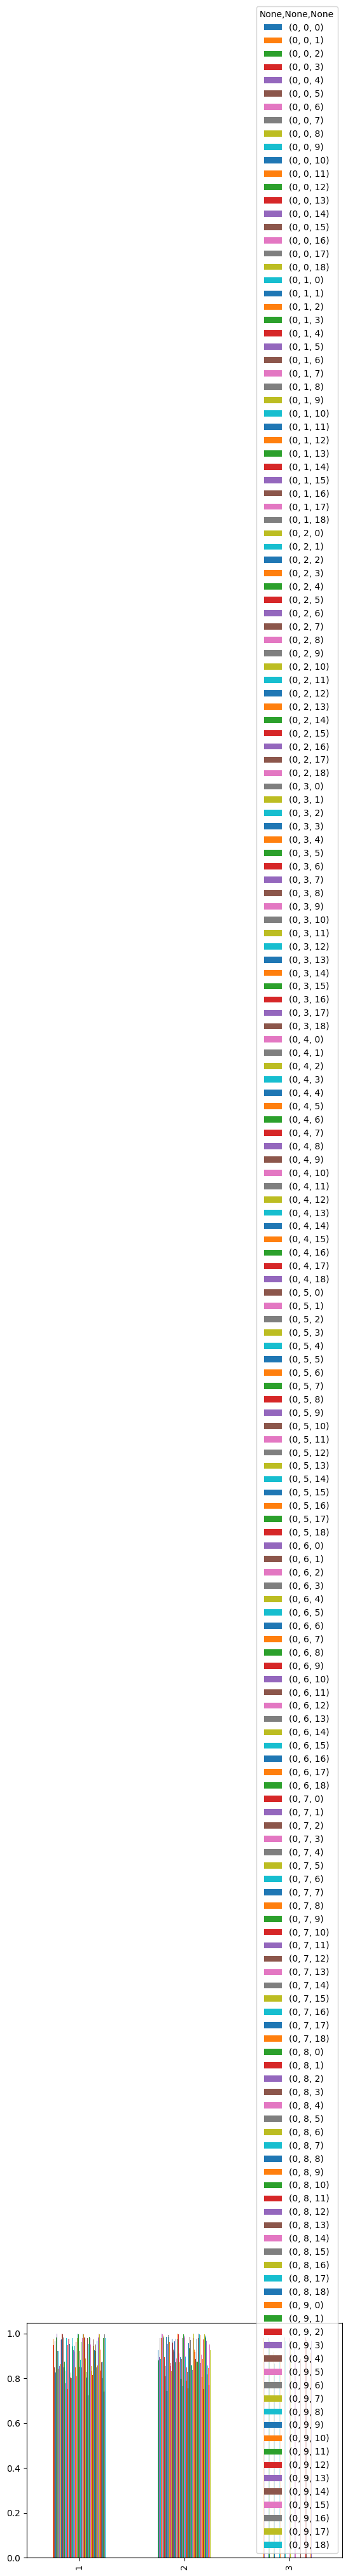

In [ ]:
# f1_validations_df.unstack().unstack().plot.bar()